## Cavity Blockade 

In this notebook, we aim to investigate the cavity blockade effect, a phenomenon in which a cavity containing a two level atom prevents the absorption of a second photon once the first one is inside. Our goal is to identify the optimal conditions for this effect to occur. To do so, we start with a driven cavity model based on the Jaynes-Cummings Hamiltonian, which describes the interaction between a two level atom and a cavity mode.

Integrate the master equation for enough large times to find the steady state. 

What is themean photon number $⟨\hat{a}^†\hat{a}⟩$? What is the steady-state occupation of the n-photon states?

Can you recover a coherent state distribution?

In [1]:
import warnings
warnings.filterwarnings('ignore') 

import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.special import factorial 
from scipy.stats import poisson

In [2]:
# Latex-like font for plots

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cmr10",
    "text.latex.preamble": r"\usepackage{amsmath, amssymb}",
})

In [3]:
N = 50         # Truncated photon Hilbert space
Delta_c = 0.0  # Detuning of the cavity (omega_c - omega)
Delta_a = 0.0  # Detuning of the atom (omega_a - omega)
g = 0.0        # Coupling strength

kappa = 0.2  # Cavity decay rate
gamma = 0.3  # Atomic decay rate
E = 0.55     # Driving amplitude

# Operators
a = qt.destroy(N)          # Cavity annihilation operator
adag = a.dag()             # Cavity creation operator
sigma_minus = qt.sigmam()  # Atomic lowering operator
sigma_plus = qt.sigmap()   # Atomic raising operator

# Tensor operators
a_full = qt.tensor(qt.qeye(2), a)                      # Cavity operator in full space
adag_full = qt.tensor(qt.qeye(2), adag)
sigma_minus_full = qt.tensor(sigma_minus, qt.qeye(N))  # Atomic operator in full space
sigma_plus_full = qt.tensor(sigma_plus, qt.qeye(N))

# Hamiltonian in RWA
H = (Delta_c * (adag_full * a_full) +
     Delta_a * (sigma_plus_full * sigma_minus_full) +
     g * (sigma_plus_full * a_full + sigma_minus_full * adag_full) +
     E * (a_full + adag_full))

EigVal, EigVec = H.eigenstates()

# Collapse operators
collapse_ops = [
    np.sqrt(kappa) * a_full,           # Cavity decay
    np.sqrt(gamma) * sigma_minus_full  # Atomic decay
]

# Initial state: atom in ground state, cavity in vacuum
psi0 = qt.tensor(qt.fock(2, 0), qt.fock(N, 0))

# Solve the master equation
dt = 0.1
times = np.arange(0, 200, dt)  # Time range
result = qt.mesolve(H, psi0, times, collapse_ops, [adag_full * a_full])

# Steady state
rho_ss = qt.steadystate(H, collapse_ops)

# Mean photon number
mean_photon_number = qt.expect(adag_full * a_full, rho_ss)
print("Mean photon number:", mean_photon_number)

# Steady-state occupation probabilities per photon number
photon_distribution = [rho_ss.ptrace(1).diag()[n] for n in range(N)]
print("Photon state probabilities:", photon_distribution)

# Theoretical Poisson distribution
def poisson_pmf(n, lam):
    return np.exp(-lam) * (lam ** n) / factorial(n)

# Fit of the histogram
n_vals = np.arange(N)
popt, pcov = curve_fit(poisson_pmf, n_vals, photon_distribution, p0=[mean_photon_number])
lam_fit = popt[0]
print("Poisson parameter from fit (lambda):", lam_fit)
print("Variance (lambda):", lam_fit)

Mean photon number: 30.020612436252367
Photon state probabilities: [np.float64(0.00015704439728718818), np.float64(0.00016284174296834995), np.float64(0.00016910572491582766), np.float64(0.0001758989679157079), np.float64(0.00018329812612415174), np.float64(0.0001914034080609215), np.float64(0.00020036696981561933), np.float64(0.00021047850885345465), np.float64(0.0002224029522335816), np.float64(0.00023777089223520935), np.float64(0.0002604818215165347), np.float64(0.0002992567114477079), np.float64(0.00037206368719519507), np.float64(0.0005128596355925811), np.float64(0.0007804466215517453), np.float64(0.0012680506017992753), np.float64(0.0021106737143423036), np.float64(0.003485889916700199), np.float64(0.005603356594734982), np.float64(0.008679672932409562), np.float64(0.012898617746521875), np.float64(0.01836168740749214), np.float64(0.02503878603644024), np.float64(0.03273197940553761), np.float64(0.0410647760726067), np.float64(0.04950486899685603), np.float64(0.0574205590723055

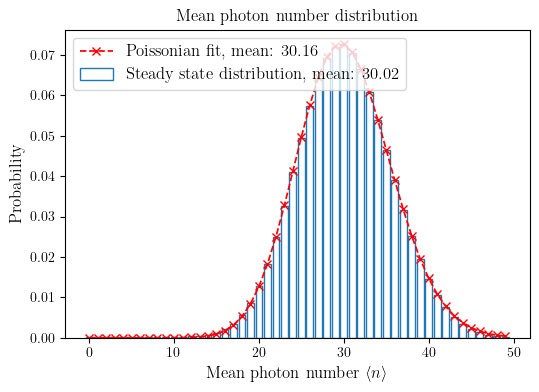

In [4]:
# Mean photon number distribution plot
plt.figure(figsize=(6, 4))
plt.bar(n_vals, photon_distribution, fill=False, edgecolor="#1f77b4", label=f"Steady state distribution, mean: {round(mean_photon_number, 2)}")
plt.plot(n_vals, poisson_pmf(n_vals, lam_fit), 'x--', c="red", linewidth=1.25, label=f"Poissonian fit, mean: {round(lam_fit, 2)}")
plt.xlabel(r"Mean photon number $\langle n \rangle$", fontsize=12)
plt.ylabel(r"Probability", fontsize=12)
plt.title(r"Mean photon number distribution", fontsize=12)
plt.legend(fontsize=12, loc="upper left")
plt.savefig("mean_photon_number_n50.pdf", dpi=300, bbox_inches='tight')
plt.show()

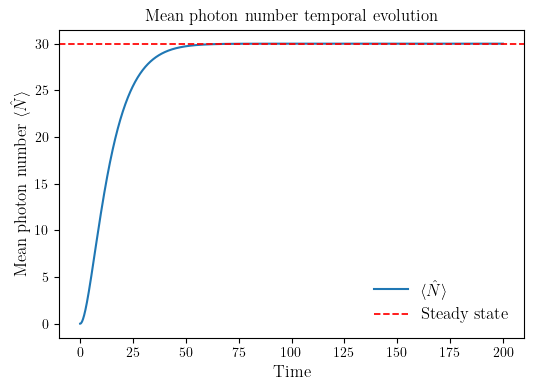

In [5]:
# Time evolution plot
plt.figure(figsize=(6, 4))
plt.plot(times, result.expect[0], label=r"$\langle \hat N \rangle$")
plt.axhline(mean_photon_number, linestyle="--", linewidth=1.25, color="red", label="Steady state")
plt.xlabel(r"Time", fontsize=12)
plt.ylabel(r"Mean photon number $\langle \hat N \rangle$", fontsize=12)
plt.title(r"Mean photon number temporal evolution", fontsize=12)
plt.legend(loc="best", frameon=False, fontsize=12)
plt.savefig("temporal_evolution_n50.pdf", dpi=300, bbox_inches='tight')
plt.show()

In the presence of a coupling $\tilde{g}$, the previous resonance condition is not valid anymore. Set $\omega$ to resonance with the lowest (one-photon) dressed state of the Jaynes-Cummings model and find again the steady state in the strong-coupling condition $\tilde{g} \gg \Gamma,\kappa$ and weak drive
$E$. 

How important is the value of the pumping strength $E$?

In [6]:
g = 10         # Strong coupling
omega_c = 9.0  # Cavity frequency
omega_a = 9.0  # Atomic frequency

Delta = omega_c - omega_a # Detuning
omega_drive = omega_c - g

kappa = 2.  # Cavity decay rate
gamma = 3.  # Atomic decay rate
E = 0.55    # Weak drive

N=6

# Operators
a = qt.destroy(N)
adag = a.dag() 
sigma_minus = qt.sigmam() 
sigma_plus = qt.sigmap()

# Tensor operators
a_full = qt.tensor(qt.qeye(2), a) # Cavity operator in full space
adag_full = qt.tensor(qt.qeye(2), adag)
sigma_minus_full = qt.tensor(sigma_minus, qt.qeye(N)) # Atomic operator in full space
sigma_plus_full = qt.tensor(sigma_plus, qt.qeye(N))

# Collapse operators
collapse_ops = [
    np.sqrt(kappa) * a_full,           # Cavity decay
    np.sqrt(gamma) * sigma_minus_full  # Atomic decay
]

# Initial state: atom in ground state, cavity in vacuum
psi0 = qt.tensor(qt.fock(2, 0), qt.fock(N, 0))

In [7]:
# Define the full Hamiltonian
def H(Delta_c, Delta_a, g, E):
     
    Hamiltonian = (Delta_c) * (adag_full * a_full) + (Delta_a) * (sigma_plus_full * sigma_minus_full) \
    + g * (sigma_plus_full * a_full + sigma_minus_full * adag_full) \
    + E * (a_full + adag_full)

    return Hamiltonian

# Set omega to resonance with the lowest dressed state
Delta_c = omega_c - omega_drive
Delta_a = omega_a - omega_drive

# Define the new Hamiltonian
H = H(Delta_c, Delta_a, g, E)

# Solve the corresponding master equation
dt = 0.1
times = np.linspace(0, 3, 2000)  # Time range
result = qt.mesolve(H, psi0, times, collapse_ops, [adag_full*a_full])
# Steady state
rho_ss = qt.steadystate(H, collapse_ops)

# Mean photon number
mean_photon_number = qt.expect(adag_full * a_full, rho_ss)
print("Mean photon number:", mean_photon_number)

# Steady-state occupation probabilities
photon_distribution = [rho_ss.ptrace(1).diag()[n] for n in range(N)]
print("Photon state probabilities:", photon_distribution)

# Poissonian fit
n_vals = np.arange(N)
popt, pcov = curve_fit(poisson_pmf, n_vals, photon_distribution, p0=[mean_photon_number])
lam_fit = popt[0]
print("Poisson parameter from fit (lambda):", lam_fit)
print("Variance (lambda):", lam_fit)

Mean photon number: 0.043065759556753104
Photon state probabilities: [np.float64(0.9574213742712643), np.float64(0.042093645358938794), np.float64(0.0004828323748390154), np.float64(2.1425410693715286e-06), np.float64(5.44451446747223e-09), np.float64(9.374058369635404e-12)]
Poisson parameter from fit (lambda): 0.04372834984718303
Variance (lambda): 0.04372834984718303


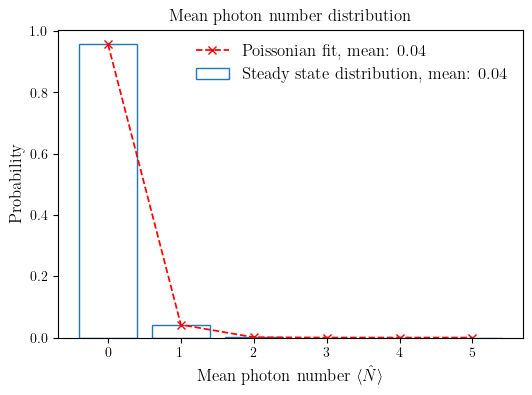

In [8]:
# Mean photon number distribution plot
plt.figure(figsize=(6, 4))
plt.bar(n_vals, photon_distribution, fill=False, edgecolor="#1f77b4", label=f"Steady state distribution, mean: {round(mean_photon_number, 2)}")
plt.plot(n_vals, poisson_pmf(n_vals, lam_fit), 'x--', c="red", linewidth=1.25, label=f"Poissonian fit, mean: {round(lam_fit, 2)}")
plt.xlabel(r"Mean photon number $\langle \hat N \rangle$", fontsize=12)
plt.ylabel(r"Probability", fontsize=12)
plt.title(r"Mean photon number distribution", fontsize=12)
plt.legend(fontsize=12, frameon=False, loc="best")
plt.savefig("mean_photon_number_n6_g.pdf", dpi=300, bbox_inches='tight')
plt.show()

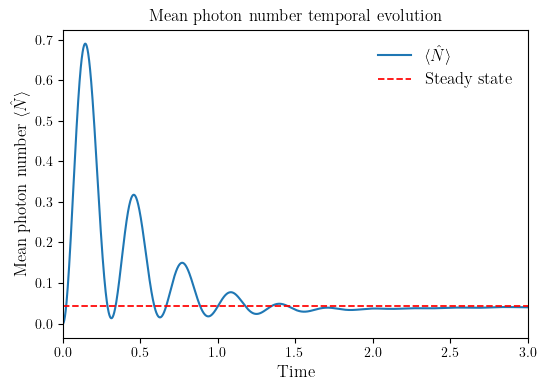

In [9]:
# Temporal evolution
plt.figure(figsize=(6, 4))
plt.plot(times, result.expect[0], label=r"$\langle \hat N \rangle$")
plt.axhline(mean_photon_number, linestyle="--", linewidth=1.25, color="red", label="Steady state")
plt.xlabel(r"Time", fontsize=12)
plt.ylabel(r"Mean photon number $\langle \hat N \rangle$", fontsize=12)
plt.title(r"Mean photon number temporal evolution", fontsize=12)
plt.xlim(0, 3)
plt.legend(loc="best", frameon=False, fontsize=12)
plt.savefig("temporal_evolution_n6_g.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# Define ranges for E and k
E_values = np.linspace(0., 40, 100)
k_values = np.linspace(0., 40, 100)

# Create the grid
X, Y = np.meshgrid(E_values, k_values)

# Matrix to save the mean photon number
z = []

# Loop over k and E 
for k in k_values:
    zz = []
    for E in E_values:
        Hamiltonian = (Delta_c) * (adag_full * a_full) + (Delta_a) * (sigma_plus_full * sigma_minus_full) \
                      + g * (sigma_plus_full * a_full + sigma_minus_full * adag_full) \
                      + E * (a_full + adag_full)

        # Define the collpase operators
        collapse_ops = [
            np.sqrt(k) * a_full,             
            np.sqrt(gamma) * sigma_minus_full   
        ]

        # Compute the steady state and the mean photon number
        rho_ss = qt.steadystate(Hamiltonian, collapse_ops)
        exp_val = qt.expect(adag_full * a_full, rho_ss)
        zz.append(exp_val)
    z.append(zz)

z = np.array(z)

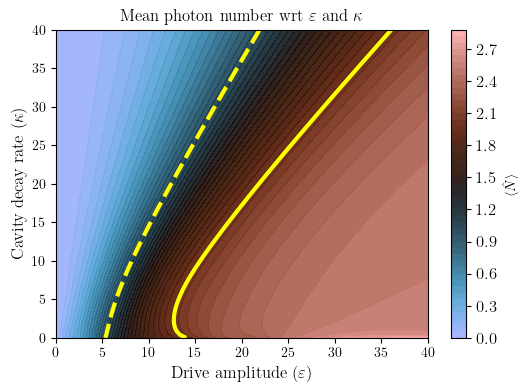

In [11]:
# Plot 
plt.figure(figsize=(6, 4))

levels = [np.min(z), 1, np.max(z)]
plt.contourf(X, Y, z, levels=50, cmap="berlin", alpha=0.9)
cbar = plt.colorbar(label=r"$\langle \hat N \rangle$")
cbar.ax.tick_params(labelsize=12)

plt.contour(X, Y, z, levels=[1], colors='yellow', linewidths=3, linestyles="--")
plt.contour(X, Y, z, levels=[2], colors='yellow', linewidths=3, linestyles="-")

plt.xlabel(r"Drive amplitude ($\varepsilon$)", fontsize=12)
plt.ylabel(r"Cavity decay rate ($\kappa$)", fontsize=12)
plt.title(r"Mean photon number wrt $\varepsilon$ and $\kappa$", fontsize=12)
plt.savefig("N_wrt_E_k.pdf", dpi=300, bbox_inches='tight')
plt.show()

Can you have occupation of two photon states? If not, why? 

What happens if you increase the values of the decay rates? And if you change $\tilde{g}$?

In [12]:
# Definiamo ranges for E and k
E_values = np.linspace(0., 40, 10)
gamma_values = np.linspace(0.0001, 40, 10)

# Create the grid
X, Y = np.meshgrid(E_values, gamma_values)

# Matrix to save the mean photon number
z = []

# Loop over gamma and E
for g in gamma_values:
    zz = []
    for E in E_values:
        Hamiltonian = (Delta_c) * (adag_full * a_full) + (Delta_a) * (sigma_plus_full * sigma_minus_full) \
                      + g * (sigma_plus_full * a_full + sigma_minus_full * adag_full) \
                      + E * (a_full + adag_full)

        # Define the collapse operators
        collapse_ops = [
            np.sqrt(kappa) * a_full,        
            np.sqrt(g) * sigma_minus_full  
        ]

        # Compute the steady state and the expected photon number
        rho_ss = qt.steadystate(Hamiltonian, collapse_ops)
        exp_val = qt.expect(adag_full * a_full, rho_ss)
        zz.append(exp_val)
    z.append(zz)

z = np.array(z)

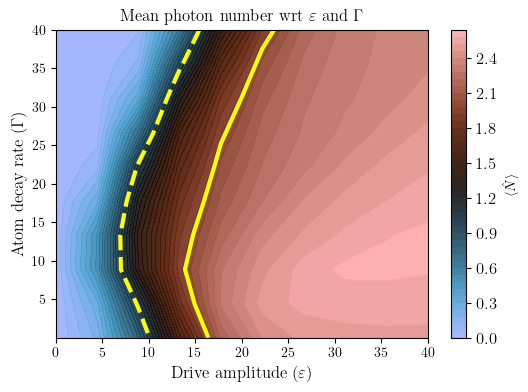

In [13]:
# Plot
plt.figure(figsize=(6, 4))

levels = [np.min(z), 1, np.max(z)]
plt.contourf(X, Y, z, levels=50, cmap="berlin", alpha=0.9)
cbar = plt.colorbar(label=r"$\langle \hat N \rangle$")
cbar.ax.tick_params(labelsize=12)

plt.contour(X, Y, z, levels=[1], colors='yellow', linewidths=3, linestyles="--")
plt.contour(X, Y, z, levels=[2], colors='yellow', linewidths=3, linestyles="-")

plt.xlabel(r"Drive amplitude ($\varepsilon$)", fontsize=12)
plt.ylabel(r"Atom decay rate ($\Gamma$)", fontsize=12)
plt.title(r"Mean photon number wrt $\varepsilon$ and $\Gamma$", fontsize=12)
plt.savefig("N_wrt_E_Gamma.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Definiamo ranges for E and k
E_values = np.linspace(0., 40, 100)
g_values = np.linspace(0., 40, 100)

# Create the grid
X, Y = np.meshgrid(E_values, g_values)

# Matrix to save the mean photon number
z = []

# Loop over g and E 
for g in g_values:
    zz = []
    for E in E_values:
        Hamiltonian = (Delta_c) * (adag_full * a_full) + (Delta_a) * (sigma_plus_full * sigma_minus_full) \
                      + g * (sigma_plus_full * a_full + sigma_minus_full * adag_full) \
                      + E * (a_full + adag_full)

        # Define the collapse operators
        collapse_ops = [
            np.sqrt(kappa) * a_full,              
            np.sqrt(gamma) * sigma_minus_full   
        ]

        # Compute the steady state and the ecpected photon number
        rho_ss = qt.steadystate(Hamiltonian, collapse_ops)
        exp_val = qt.expect(adag_full * a_full, rho_ss)
        zz.append(exp_val)
    z.append(zz)

z = np.array(z)

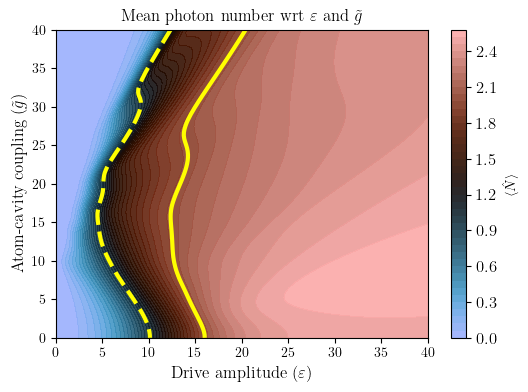

In [15]:
# Plot
plt.figure(figsize=(6, 4))

levels = [np.min(z), 1, np.max(z)]
plt.contourf(X, Y, z, levels=50, cmap="berlin", alpha=0.9)
cbar = plt.colorbar(label=r"$\langle \hat N \rangle$")
cbar.ax.tick_params(labelsize=12)

plt.contour(X, Y, z, levels=[1], colors='yellow', linewidths=3, linestyles="--")
plt.contour(X, Y, z, levels=[2], colors='yellow', linewidths=3, linestyles="-")

plt.xlabel(r"Drive amplitude ($\varepsilon$)", fontsize=12)
plt.ylabel(r"Atom-cavity coupling ($\tilde{g}$)", fontsize=12)
plt.title(r"Mean photon number wrt $\varepsilon$ and $\tilde{g}$", fontsize=12)
plt.savefig("N_wrt_E_g.pdf", dpi=300, bbox_inches='tight')
plt.show()

A way to understand the suppression of two-photon states is to compute the two-photon
correlation function 

\begin{equation*}
    g^{(2)} \equiv \frac{⟨\hat{a}^\dagger \hat{a}^\dagger \hat{a} \hat{a}⟩}{|⟨\hat{a}^\dagger \hat{a}⟩|^2}

\end{equation*}

which compares the probability to find two simultaneous photons with the one of having to independent photons at random. In the blockade regime, you should find $g^{(2)}<1$.

In [16]:
g = 10         # Strong coupling
omega_c = 1.0  # Cavity frequency
omega_a = 1.0  # Atomic frequency

Delta = omega_c - omega_a
omega_drive = omega_c - g

kappa = 2.  
gamma = 3.  
E = 0.55  # Weak drive

N=5

# Operators
a = qt.destroy(N)       
adag = a.dag()       
sigma_minus = qt.sigmam()  
sigma_plus = qt.sigmap()   

# Tensor operators
a_full = qt.tensor(qt.qeye(2), a)      
adag_full = qt.tensor(qt.qeye(2), adag)
sigma_minus_full = qt.tensor(sigma_minus, qt.qeye(N))  
sigma_plus_full = qt.tensor(sigma_plus, qt.qeye(N))

# Collapse operators
collapse_ops = [
    np.sqrt(kappa) * a_full,        
    np.sqrt(gamma) * sigma_minus_full 
]

# Initial state: atom in ground state, cavity in vacuum
psi0 = qt.tensor(qt.fock(2, 0), qt.fock(N, 0))

# Define the full Hamiltonian
def H(Delta_c, Delta_a, g, E):
     
    Hamiltonian = (Delta_c) * (adag_full * a_full) + (Delta_a) * (sigma_plus_full * sigma_minus_full) \
    + g * (sigma_plus_full * a_full + sigma_minus_full * adag_full) \
    + E * (a_full + adag_full)

    return Hamiltonian

In [17]:
# Set omega to resonance with the lowest dressed state
Delta_c = omega_c - omega_drive
Delta_a = omega_a - omega_drive
H = H(Delta_c, Delta_a, g, E)

rho_ss = qt.steadystate(H, collapse_ops)
g2 = qt.expect(adag_full*adag_full*a_full*a_full, rho_ss)/qt.expect(adag_full*a_full, rho_ss)**2
print(r"g_2(0):", g2)

g_2(0): 0.5276357977934922


Scan the values of ω around the resonance and graphically represent your findings.

In [18]:
omega = np.linspace(-20, 40, 2000) 
times = np.linspace(0.0, 200, 2000)

 
g = 10        # Strong coupling
omega_c = 9.  # Cavity frequency
omega_a = 9.  # Atomic frequency

Delta = omega_c - omega_a
omega_drive = omega_c - g
print(omega_drive)

kappa = 2. 
gamma = 3. 
E = 0.55  

N=6
 
# Operators 
a = qt.destroy(N)       
adag = a.dag()       
sigma_minus = qt.sigmam() 
sigma_plus = qt.sigmap()  
 
# Tensor operators 
a_full = qt.tensor(qt.qeye(2), a)    
adag_full = qt.tensor(qt.qeye(2), adag) 
sigma_minus_full = qt.tensor(sigma_minus, qt.qeye(N))  
sigma_plus_full = qt.tensor(sigma_plus, qt.qeye(N)) 
 
# Collapse operators 
collapse_ops = [ 
    np.sqrt(kappa) * a_full,  
    np.sqrt(gamma) * sigma_minus_full  
] 
 
# Initial state: atom in ground state, cavity in vacuum 
psi0 = qt.tensor(qt.fock(2, 0), qt.fock(N, 0)) 
   
 
# Compute and store g_2 values
g_list = [] 
n=[] 
 
for o in omega: 
    Delta_c = omega_c - o 
    Delta_a = omega_a - o 
    H =  (Delta_c) * (adag_full * a_full) + (Delta_a) * (sigma_plus_full * sigma_minus_full) + g * (sigma_plus_full * a_full + sigma_minus_full * adag_full) + E * (a_full + adag_full)  # Calcolare l'Hamiltoniana 
 
    # Risolvi l'equazione di master 
    rho_ss = qt.steadystate(H, collapse_ops) 
 
    g2 = qt.expect(adag_full * adag_full * a_full * a_full, rho_ss) / qt.expect(adag_full * a_full, rho_ss)**2 
    g_list.append(g2) 
 
    nn=qt.expect(adag_full*a_full, rho_ss) 
    n.append(nn) 
     
print(g_list)

-1.0
[0.9853635648392647, 0.9853018983418472, 0.9852399096830526, 0.9851775928870787, 0.9851149430116952, 0.9850519668035754, 0.9849886547097645, 0.9849250067951519, 0.9848610196099287, 0.9847966935101752, 0.9847320264738592, 0.9846670134403164, 0.9846016554596938, 0.9845359443136485, 0.9844698858970504, 0.9844034742630259, 0.9843367039905937, 0.9842695784437094, 0.9842020911142115, 0.9841342425161466, 0.9840660285951252, 0.9839974469559579, 0.9839284959733724, 0.9838591712895551, 0.9837894744205815, 0.9837194002526829, 0.9836489458077537, 0.983578110461552, 0.9835068907155442, 0.9834352839859756, 0.9833632853306831, 0.9832908982801701, 0.9832181162531962, 0.9831449361271576, 0.9830713572998133, 0.9829973750391743, 0.982922988471403, 0.9828481950055098, 0.9827729914529212, 0.9826973735196436, 0.9826213396454596, 0.9825448888752397, 0.9824680162693508, 0.9823907198657739, 0.982312995628398, 0.9822348428772798, 0.9821562571639603, 0.9820772359596198, 0.981997777274352, 0.9819178754725396

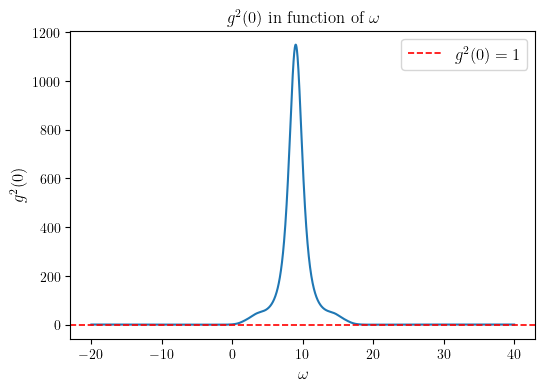

In [19]:
# Plot the master equation 
plt.figure(figsize=(6, 4)) 
plt.plot(omega, g_list) 
plt.xlabel(r"$\omega$", fontsize=12) 
plt.ylabel(r"$g^2(0)$", fontsize=12) 
plt.title(r"$g^2(0)$ in function of $\omega$")
plt.axhline(1, c="red", linestyle="--", linewidth=1.2, label=r"$g^2(0)=1$")
plt.legend(loc="best", fontsize=12)
plt.savefig("g2_vs_omega.pdf", dpi=300, bbox_inches='tight')
plt.show() 

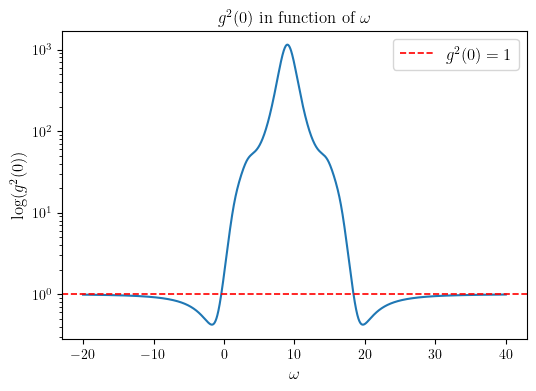

In [20]:
# Plot the master equation 
plt.figure(figsize=(6, 4))
plt.yscale("log") 
plt.plot(omega, g_list) 
plt.xlabel(r"$\omega$", fontsize=12) 
plt.ylabel(r"log($g^2(0)$)", fontsize=12) 
plt.title(r"$g^2(0)$ in function of $\omega$")
plt.axhline(1, c="red", linestyle="--", linewidth=1.2, label=r"$g^2(0)=1$")
plt.legend(loc="best", fontsize=12)
plt.savefig("g2_vs_omega_log.pdf", dpi=300, bbox_inches='tight')
plt.show()

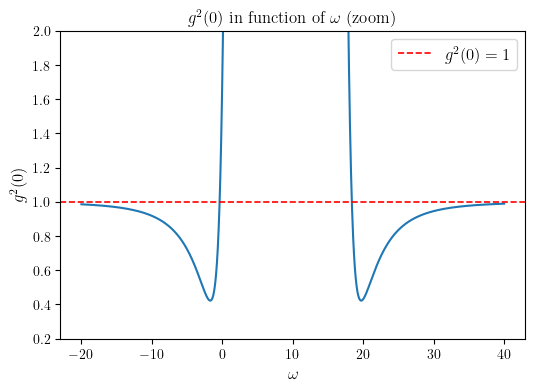

In [21]:
# Plot a zoom of the master equation 
plt.figure(figsize=(6, 4)) 
plt.plot(omega, g_list) 
plt.xlabel(r"$\omega$", fontsize=12) 
plt.ylabel(r"$g^2(0)$", fontsize=12) 
plt.title(r"$g^2(0)$ in function of $\omega$ (zoom)")
plt.axhline(1, c="red", linestyle="--", linewidth=1.2, label=r"$g^2(0)=1$")
plt.ylim(0.2, 2)
plt.legend(loc="best", fontsize=12)
plt.savefig("g2_vs_omega_zoom.pdf", dpi=500, bbox_inches='tight')
plt.show()

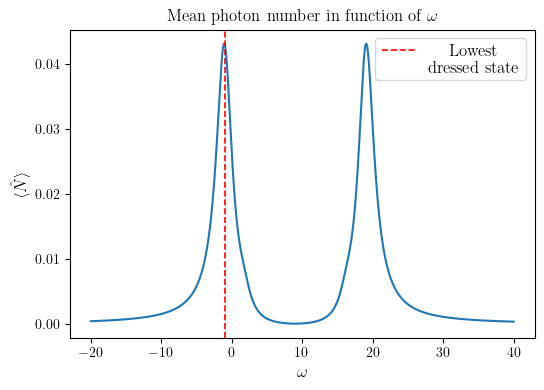

In [22]:
plt.figure(figsize=(6, 4)) 
plt.plot(omega, n) 
plt.axvline(omega_drive, c="red", linestyle="--", linewidth=1.2, label=r"Lowest \\ dressed state")
plt.xlabel(r"$\omega$", fontsize=12) 
plt.ylabel(r"$\langle \hat N \rangle$", fontsize=12) 
plt.title(r"Mean photon number in function of $\omega$")
plt.legend(loc="best", fontsize=12)
plt.savefig("N_vs_omega.pdf", dpi=300, bbox_inches='tight')
plt.show()